# Deep Learning with PyTorch

There is an emergence of new machine learning techniques that mimic the way the brain processes information in a structure called an artificial neural network.
PyTorch is a framework for creating machine learning models, including deep neural networks (DNNs).

# Explore the Dataset

In [1]:
import pandas as pd

penguins = pd.read_csv('data/penguins.csv').dropna()

# Deep Learning models work best when features are on similar scales
# In a real solution, we'd implement some custom normalization for each
# feature, but to keep things simple
penguins['FlipperLength'] = penguins['FlipperLength']/10
penguins['BodyMass'] = penguins['BodyMass']/100

# The dataset is too small to be useful for deep learning
# so we'll oversample it to triple its size
for i in range(1,3):
    penguins = penguins.append(penguins)

# Display a random sample of 10 observations
sample = penguins.sample(10)
sample

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
33,40.9,18.9,18.4,39.0,0
243,52.2,17.1,22.8,54.0,1
331,52.2,18.8,19.7,34.5,2
149,37.8,18.1,19.3,37.5,0
292,50.3,20.0,19.7,33.0,2
307,54.2,20.8,20.1,43.0,2
206,46.5,14.4,21.7,49.0,1
86,36.3,19.5,19.0,38.0,0
291,50.5,19.6,20.1,40.5,2
105,39.7,18.9,18.4,35.5,0


In [2]:
# to show the actual species to which these class labels correspond
classes = ['Amelie', 'Gentoo', 'Chinstrap']
print(penguins.columns[0:5].values, 'SpeciesName')
for ind, row in penguins.sample(10).iterrows():
    print('[',row[0],row[1],row[2],row[3],row[4],']', classes[int(row[-1])])

['CulmenLength' 'CulmenDepth' 'FlipperLength' 'BodyMass' 'Species'] SpeciesName
[ 43.3 13.4 20.9 44.0 1.0 ] Gentoo
[ 36.2 16.1 18.7 35.5 0.0 ] Amelie
[ 41.1 17.6 18.2 32.0 0.0 ] Amelie
[ 35.6 17.5 19.1 31.75 0.0 ] Amelie
[ 52.7 19.8 19.7 37.25 2.0 ] Chinstrap
[ 49.8 17.3 19.8 36.75 2.0 ] Chinstrap
[ 36.3 19.5 19.0 38.0 0.0 ] Amelie
[ 34.1 18.1 19.3 34.75 0.0 ] Amelie
[ 37.2 18.1 17.8 39.0 0.0 ] Amelie
[ 45.8 14.6 21.0 42.0 1.0 ] Gentoo


In [3]:
from sklearn.model_selection import train_test_split
feats = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
label = 'Species'

# Split data 7-3 into training set and test set
x_train, x_test, y_train, y_test = train_test_split(penguins[feats].values, 
                                                    penguins[label].values,
                                                    test_size = 0.3,
                                                    random_state = 0)
print('Training Set: %d, Test Set: %d \n'%(len(x_train), len(x_test)))
print('Sample of features and labels:')

for n in range(0,5):
    print(x_train[n], y_train[n],'(' + classes[y_train[n]] + ')')

Training Set: 957, Test Set: 411 

Sample of features and labels:
[51.1 16.5 22.5 52.5] 1 (Gentoo)
[50.7 19.7 20.3 40.5] 2 (Chinstrap)
[49.5 16.2 22.9 58. ] 1 (Gentoo)
[39.3 20.6 19.  36.5] 0 (Amelie)
[42.5 20.7 19.7 45. ] 0 (Amelie)


# Install and import the PyTorch Libraries

In [4]:
# to ensure that PyTorch was installed correctly
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.8288, 0.4727, 0.2535],
        [0.9261, 0.9168, 0.9693],
        [0.3117, 0.2218, 0.4828],
        [0.5452, 0.9195, 0.3218],
        [0.5057, 0.8437, 0.4553]])


In [5]:
# to check if my GPU driver and CUDA is enabled and accessible by PyTorch
torch.cuda.is_available()

False

In [6]:
import torch
import torch.nn as nn
import torch.utils.data as td

# Set random seed for reproducability
torch.manual_seed(0)

print('Libraries imported - ready to use PyTorch', torch.__version__)

Libraries imported - ready to use PyTorch 1.8.0


# Prepare the data for PyTorch

PyTorch makes use of *data loader* to load training and validation data in batches. We've already loaded the data into numpy arrays, but we need to wrap those in PyTorch datasets (where the data is converted to PyTorch *tensor* objects) and create loaders to read batches from those datasets.

In [7]:
# Create a dataset and loader for the training data and labels
# .float(): 32-bit floating point
# .long(): 64-bit integer (signed)
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).long()
train_ds = td.TensorDataset(train_x, train_y)
train_loader = td.DataLoader(train_ds, batch_size=20,
                             shuffle=False, num_workers=1)

test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).long()
test_ds = td.TensorDataset(test_x, test_y)
test_loader = td.DataLoader(test_ds, batch_size=20,
                            shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


# Define a neural network

In this case, we will create a network that consists of 3 fully-connected layers:
* An input layer that receives an input value for each feature and applies a *ReLU* activation function.
* A hidden layer that receives ten inputs ten and applies a *ReLU* activation function.
* An output layer that uses a *Softmax* activation function to generate an output for each classification. Softmax functions produce a vector with probability values that sum to 1. 

In [8]:
# Number of hidden layer nodes
hl = 10

# Define the neural network
class PenguinNet(nn.Module):
    def __init__(self):
        super(PenguinNet, self).__init__()
        self.fc1 = nn.Linear(len(feats), hl)
        self.fc2 = nn.Linear(hl, hl)
        self.fc3 = nn.Linear(hl, len(classes))
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x

# Create a model instance from the network
model = PenguinNet()
print(model)

PenguinNet(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)


# Train the model

To train the model, we need to repeatedly feed the training values forward through the network, use a loss function to calculate the loss, use an optimizer to backpropagate the weight and bias value adjustments, and validate the model using the test data we withheld.

In [11]:
def train(model, data_loader, optimizer):
    # Set the model to training mode
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data)
        loss = loss_criteria(out, target)
        train_loss += loss.item()
        
        # backpropagate
        loss.backward()
        optimizer.step()
        
    # Return average loss
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

def test(model, data_loader):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data)
            
            # Calculate the loss
            test_loss += loss_criteria(out, target).item()
            
            # Calculate the accuracy
            _, predicted = torch.max(out.data, 1)
            correct += torch.sum(target==predicted).item()
        
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            avg_loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset)))
        
    # Return average loss for the epoch
    return avg_loss
    
# Specify the loss criteria (CrossEntropyLoss for multi-class classification)
loss_criteria = nn.CrossEntropyLoss()

# Use an "Adam" optimizer to adjust weights
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# We'll track metrics for each epoch on these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Training over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)
        

Epoch: 1
Training set: Average loss: 1.003117
Validation set: Average loss: 0.988074, Accuracy: 293/411 (71%)

Epoch: 2
Training set: Average loss: 0.962624
Validation set: Average loss: 0.948942, Accuracy: 316/411 (77%)

Epoch: 3
Training set: Average loss: 0.920042
Validation set: Average loss: 0.905124, Accuracy: 321/411 (78%)

Epoch: 4
Training set: Average loss: 0.874844
Validation set: Average loss: 0.862565, Accuracy: 328/411 (80%)

Epoch: 5
Training set: Average loss: 0.830764
Validation set: Average loss: 0.823208, Accuracy: 339/411 (82%)

Epoch: 6
Training set: Average loss: 0.790008
Validation set: Average loss: 0.784854, Accuracy: 353/411 (86%)

Epoch: 7
Training set: Average loss: 0.752937
Validation set: Average loss: 0.748247, Accuracy: 369/411 (90%)

Epoch: 8
Training set: Average loss: 0.720251
Validation set: Average loss: 0.717467, Accuracy: 389/411 (95%)

Epoch: 9
Training set: Average loss: 0.693244
Validation set: Average loss: 0.692360, Accuracy: 393/411 (96%)

E

ps. with torch.no_grad():
https://zhuanlan.zhihu.com/p/67184419
当我们在做 evaluating 的时候（不需要计算导数），我们可以将推断（inference）的代码包裹在 with torch.no_grad(): 之中，以达到 暂时 不追踪网络参数中的导数的目的，总之是为了减少可能存在的计算和内存消耗

ps. RuntimeError: bool value of Tensor with more than one value is ambiguous
最常見的地方在於 Loss Function 的使用，通常是誤用了 Class 作為輸入
https://clay-atlas.com/blog/2020/05/16/pytorch-cn-error-runtimeerror-ambiguous/
nn.CrossEntropyLoss()是一個 Class，我們需要將其建立為物件才可以輸入『預測結果』與『正確答案』

1. In each epoch, the full set of training data is passed forward through the network. For efficiencym the feature vectors are grouped into batches.
2. The matrix of feature values is processed by a function performing a weighted sum using initialized weights and bias values. The result of this function is then processed by the activation function for the input layer to constrain the values passed to the nodes in the next layer.
3. The weighted sum and activation functions are repeated in each layer. 
4. In the final layer of the network, the output vectors, containing a probability value for each possible class, is processed by a loss function to determine how far the values calculated by the network are from the actual values.
5. At the end of each epoch, the validation data is passed through the network, and its loss and accuracy are also calculated. It's important to do this because it enables us to compare the performance of the model using data on which it was not trained, helping us determine if it will generalize well for new data or if it's overfitted to the training data.
6. After all the data has been passed forward through the network, the output of the loss function for the training data (but not the validation data) is passed to the optimizer. The entire network from the input layer to the loss function is one big nested (composite) function. The optimizer applies some differential calculus to calculate partial derivatives for the function with respect to each weight and bias value used in the network. It's possible to do this efficiently for a nested function due to something called the chain rule, enabling you to determine the derivative of a composite function from the derivatives of its inner function and outer functions. The end result is that the partial derivatives tell us about the slope (or gradient) of the loss function. We can determine whether to increase or decrease the weight and bias values in order to decrease the loss.
7. Having determined in which direction to adjust the weights and biases, the optimizer uses the learning rate to determine by how much to adjust them, and then works backwards through the network in a process called backpropagation to assign new values to the weights and biases in each layer.
8. Now the next epoch repeats the whole training, validation, and backpropagation process starting with the revised weights and biases from the previous epoch - which hopefully will result in a lower level of loss.


# Review training and validation loss

After training is complete, by examining the loss metrics, we're really looking for 2 things:
* The loss should reduce with each epoch, showing that the model is learning the right weights and biases to predict the correct labels.
* The training loss and validation loss should follow a similar trend, showing that the model is not overfitting to the training data.

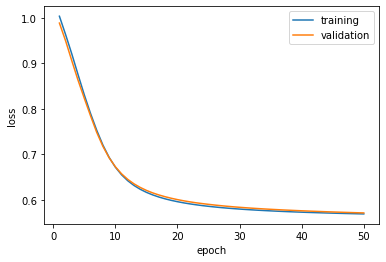

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# View the learned weights and biases

The trained model consists of the final weights and biases that were detemined by the optimizer during training.
* Layer 1: There are 4 input values going to 10 output nodes, so there should be 10x4 weights and 10 bias values.
* Layer 2: 10x10 weights and 10 bias values
* Layer 3: 3x10 weights and 3 bias values

In [13]:
for param_tensor in model.state_dict():
    print(param_tensor, '\n', model.state_dict()[param_tensor].numpy())

fc1.weight 
 [[-0.00374341  0.2682218  -0.41152257 -0.3679695 ]
 [-0.21311925 -0.2744664   0.13805772  0.6008754 ]
 [-0.04437202  0.13230628 -0.15110654 -0.09828269]
 [-0.47767425 -0.33114105 -0.20611155  0.01852179]
 [ 0.17988217  0.2820575  -0.3566924  -0.23511334]
 [ 0.3894448   0.35169297 -0.20544158  0.36354285]
 [-0.08059168  0.05290705  0.4527381  -0.46383518]
 [-0.35729307 -0.1673987  -0.2368747   0.3890607 ]
 [-0.32408983 -0.23016644 -0.34932023 -0.4682805 ]
 [-0.4298822   0.7961434   0.29358077  0.1772558 ]]
fc1.bias 
 [ 0.02629578 -0.26014262  0.08459234 -0.46684736 -0.3790015  -0.44093236
  0.31546897  0.25169232 -0.22174752  0.23264474]
fc2.weight 
 [[ 0.20224687  0.3143725   0.12550515  0.04272011  0.21202639 -0.18619564
   0.05892715 -0.24517313 -0.21917307 -0.16335806]
 [ 0.14308453  0.1578964  -0.18731831  0.09553465  0.19169767  0.1473398
   0.01207405  0.03876313  0.19618031  0.9051269 ]
 [-0.24369258 -0.14273338  0.12428063  0.2620103   0.25947636  0.3239681
   0.06

# Evaluate model performance

It's typically useful to dig a little deeper and compare the predictions for each possible class. A common way to visualize the performance of a classification model is to create a confusion matrix showing a crosstab of correct and incorrect predictions for each class.

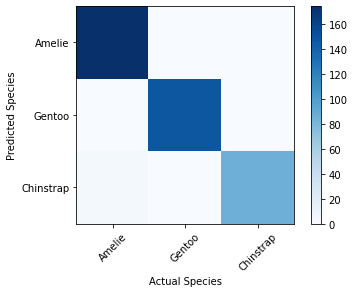

In [14]:
# Pytorch doesn't have a built-in confusion matrix metric, 
# so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix
import numpy as np

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data
x = torch.Tensor(x_test).float()
_, predicted = torch.max(model(x).data, 1)

# Plot the confusion matrix
cm = confusion_matrix(y_test, predicted.numpy())
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Actual Species")
plt.ylabel("Predicted Species")
plt.show()


The confusion matrix shows a strong diagonal line indicating that there are more correct than incorrect predictions for each class.

# Save the trained model

In [17]:
# Save the model weights
model_file = 'penguin_classifier.pt'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

model saved as penguin_classifier.pt


# Use the trained model

In [18]:
# New penguin features
x_new = [[50.4,15.3,20,50]]
print('New sample: {}'.format(x_new))

# Create a new model class and load weights
model = PenguinNet()
model.load_state_dict(torch.load(model_file))

# Set model to evaluation mode
model.eval()

# Get a prediction for the new data sample
x = torch.Tensor(x_new).float()
_, predicted = torch.max(model(x).data, 1)

print('Prediction:', classes[predicted.item()])

New sample: [[50.4, 15.3, 20, 50]]
Prediction: Gentoo


https://pytorch.org/tutorials/